In [2]:
import numpy as np
import matplotlib.pylab as plt
import uproot
import awkward as ak
import seaborn
import RA_funcs as rf
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.special import gamma



imports work


In [3]:
hit_data_1093 = rf.get_ROOT_data_zip_RECO(1093)
# hit_data_1088 = rf.get_ROOT_data_zip_RECO(1088)

1093 RECONSTRUCTED finished


In [4]:
a = hit_data_1093[hit_data_1093.amp > 800]
b = a[ak.num(a) > 0 ]
c = b[b.plane == 5]
c = c[ak.num(c) > 0 ]
c

<Array [[{plane: 5, ch: 124, ...}], ...] type='33940 * var * {plane: int32,...'>

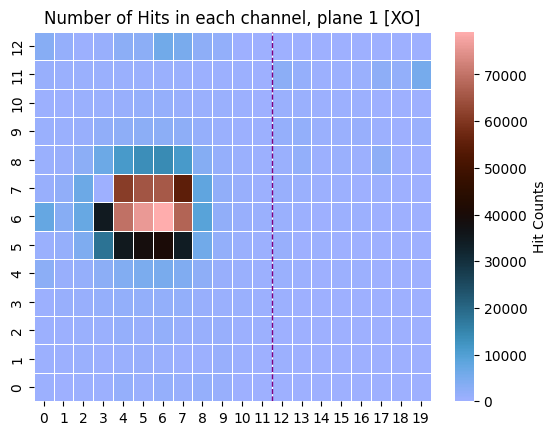

In [5]:
rf.hits_amount_colormap_single_plane(hit_data_1093,1)

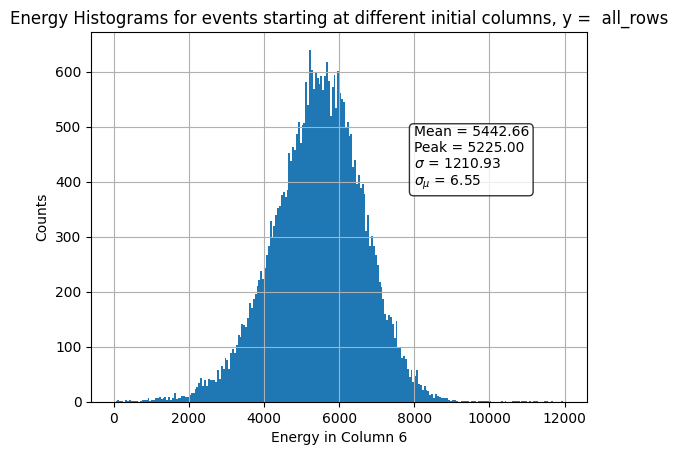

In [6]:
rf.shower_energy_histo_single_location(hit_data_1093, 6, bin_size=50)


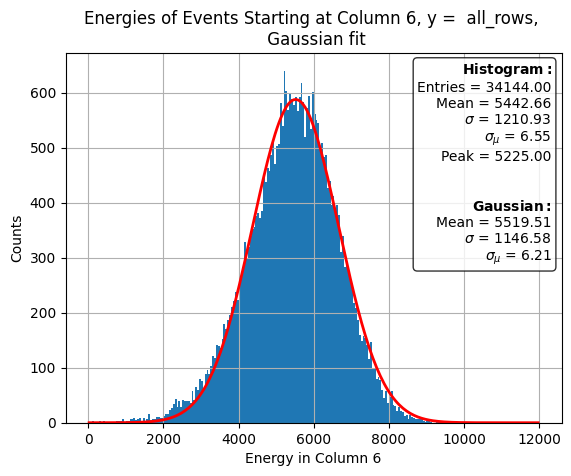

In [7]:
rf.Single_column_energy_histo_Gaussian_fit(hit_data_1093, 6, bin_size=50)

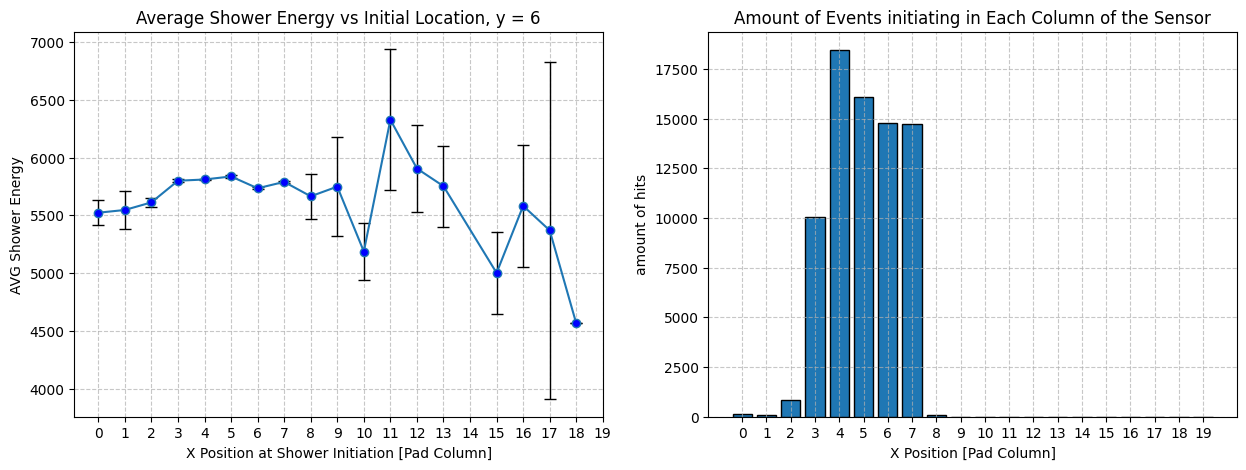

In [8]:
rf.event_shower_energy_vs_X_position(hit_data_1093, single_pad_only = "true", specific_Y=6)

In [9]:
hit_data_1340 = rf.get_ROOT_data_zip_RECO_11(1340)


1340 RECONSTRUCTED finished


In [10]:
def channel_data_correction(hit_data, plane, dead_channel):

    # determine the surrounding pads
    neighbor_ch = [dead_channel+1, dead_channel-1, dead_channel+21, dead_channel+20, dead_channel+19, dead_channel-19, dead_channel-20,dead_channel-21]
    
    # get the data in the wanted plane
    hit_data_plane = hit_data[hit_data.plane == plane]

    # get the data to only the surrounding pads

    # calculate the average energy of surrounding pads to determine the energy in the dead one

    # attach the corrected data to the original



In [90]:
hit_data_scope_1093 = rf.DUT_TELE_merge(1093)

[[0], [1], [2], [3], [4], ..., [500617], [500618], [500619], [500620], [500621]]
[[1], [2], [3], [4], [5], ..., [500613], [500614], [500615], [500616], [500617]]
440902
440902


In [ ]:
# hit_data_scope_1093.tele[hit_data_scope_1093.tele.chired < 3]

mask = hit_data_scope_1093.tele.chired < 3
a = hit_data_scope_1093[mask]
a[ak.num(a.tele) > 0]

<Array [{hits: [{...}], tele: ..., ...}, ...] type='364284 * {hits: var * {...'>

In [106]:
def filter_chi2_scope_data(hit_data_scope, upper_chi2_bound):
    mask = hit_data_scope.tele.chired < upper_chi2_bound
    filtered_data = hit_data_scope[mask]
    filtered_data_clean = filtered_data[ak.num(filtered_data.tele) > 0]
    return filtered_data_clean

In [108]:
hit_data_scope_1093_chi2_3 = filter_chi2_scope_data(hit_data_scope_1093, 3)
hit_data_scope_1093_chi2_3

<Array [{hits: [{...}], tele: ..., ...}, ...] type='364284 * {hits: var * {...'>

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

X = -ak.to_numpy(ak.mean(hit_data_scope_1093.x, axis=1))
Y = ak.to_numpy(ak.mean(hit_data_scope_1093.y, axis=1))
amp = ak.to_numpy(ak.sum(hit_data_scope_1093.amp, axis=1))

# Define bins
bins = 100

# Histogram of SUM of amplitudes
sum_amp, xedges, yedges = np.histogram2d(X, Y, bins=bins, weights=amp)

# Histogram of COUNTS
counts, _, _ = np.histogram2d(X, Y, bins=[xedges, yedges])

# Avoid division by zero
avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

# Plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, avg_amp.T, cmap="tab20c")  
plt.colorbar(label="Average Amplitude")
plt.xlim(min(X), max(X))
plt.ylim(min(Y), max(Y))
# plt.xlim(-20, 20)
# plt.ylim(-20, 20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram of Average Amplitude - run 1093")
plt.show()


AttributeError: no field named 'x'

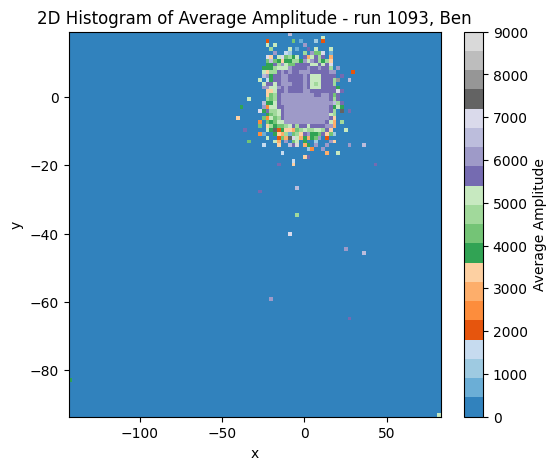

In [99]:
X_ben1 = ak.flatten(hit_data_scope_1093.tele.x)
Y_ben1 = ak.flatten(hit_data_scope_1093.tele.y)

X_ben = -ak.to_numpy(X_ben1)
Y_ben = ak.to_numpy(Y_ben1)

amp_ben1 = ak.sum(hit_data_scope_1093.hits.amp, axis = 1)
amp_ben = ak.to_numpy(amp_ben1)

# Define bins
bins = 100

# Histogram of SUM of amplitudes
sum_amp, xedges, yedges = np.histogram2d(X_ben, Y_ben, bins=bins, weights=amp_ben)

# Histogram of COUNTS
counts, _, _ = np.histogram2d(X_ben, Y_ben, bins=[xedges, yedges])

# Avoid division by zero
avg_amp = np.divide(sum_amp, counts, out=np.zeros_like(sum_amp), where=counts > 0)

# Plot
plt.figure(figsize=(6,5))
plt.pcolormesh(xedges, yedges, avg_amp.T, cmap="tab20c")  
plt.colorbar(label="Average Amplitude")
plt.xlim(min(X_ben), max(X_ben))
# plt.xlim(-20, 20)
plt.ylim(min(Y_ben), max(Y_ben))
# plt.ylim(-20, 20)
plt.xlabel("x")
plt.ylabel("y")
plt.title("2D Histogram of Average Amplitude - run 1093, Ben")
plt.show()


C:\Users\bents\AppData\Local\Programs\Python\Python313\Lib\site-packages\awkward\_nplikes\array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


Text(0, 0.5, 'amplitude (avg ± std)')

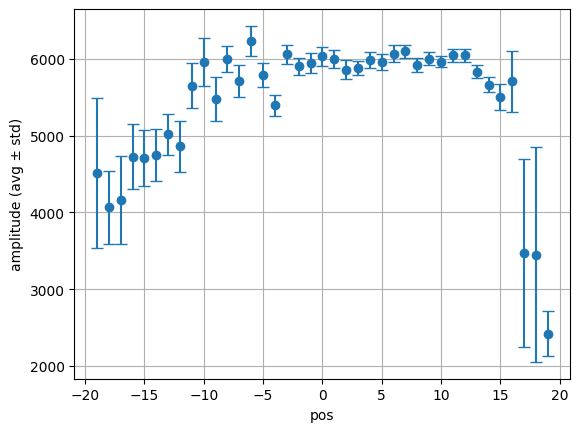

In [46]:
y_max, y_min = -7, -9

data = hit_data_scope_1093[(hit_data_scope_1093.y < y_max) & (hit_data_scope_1093.y > y_min)]
data = data[ak.num(data) > 0]

X = -ak.to_numpy(ak.mean(data.x, axis=1))
np.round(X)
E = ak.sum(data.amp, axis = 1)
amp,mean,pos = rf.ak_groupby(X,E)
amp_avg = ak.mean(amp.data, axis = 1)
amp_std = ak.std(amp.data, axis = 1) / np.sqrt(ak.num(amp.data, axis = 1) -1)
mask = (pos > -20) & (pos < 20) 
# plt.scatter(pos[mask],amp[mask])
plt.errorbar(pos[mask],amp_avg[mask],yerr=amp_std[mask],fmt='o',capsize=4)
plt.grid()
plt.xlabel("pos")
plt.ylabel("amplitude (avg ± std)")


Text(0, 0.5, 'amplitude (avg ± std)')

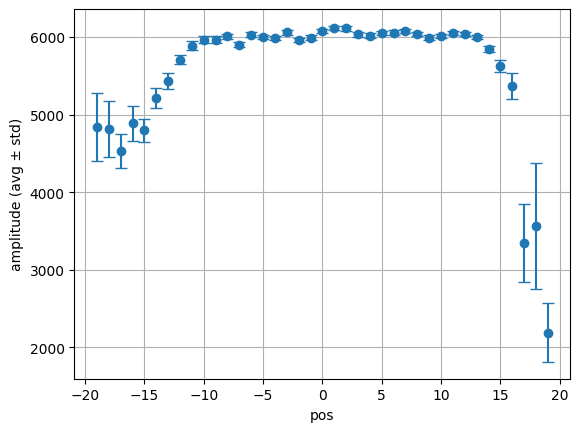

In [ ]:
y_max, y_min = -5, -10

data = hit_data_scope_1093[(hit_data_scope_1093.y < y_max) & (hit_data_scope_1093.y > y_min)]
data = data[ak.num(data) > 0]

X = -ak.to_numpy(ak.mean(data.x, axis=1))
np.round(X)
E = ak.sum(data.amp, axis = 1)
amp,mean,pos = rf.ak_groupby(X,E)
amp_avg = ak.mean(amp.data, axis = 1)
amp_std = ak.std(amp.data, axis = 1) / np.sqrt(ak.num(amp.data, axis = 1) -1)
mask = (pos > -20) & (pos < 20) 
# plt.scatter(pos[mask],amp[mask])
plt.errorbar(pos[mask],amp_avg[mask],yerr=amp_std[mask],fmt='o',capsize=4)
plt.grid()
plt.xlabel("pos")
plt.ylabel("amplitude (avg ± std)")


Text(0, 0.5, 'amplitude (avg ± std)')

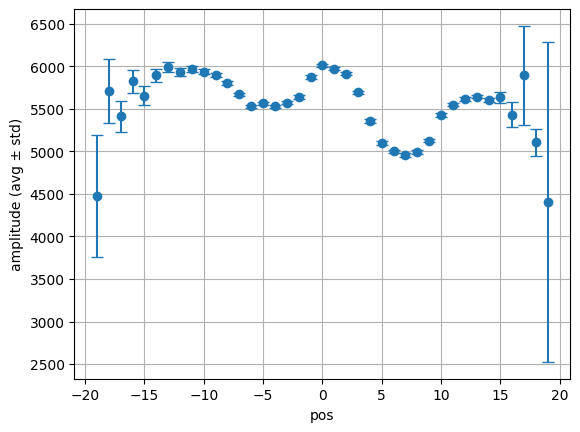

In [ ]:
y_max, y_min = 6, 3

data = hit_data_scope_1093[(hit_data_scope_1093.y < y_max) & (hit_data_scope_1093.y > y_min)]
data = data[ak.num(data) > 0]

X = -ak.to_numpy(ak.mean(data.x, axis=1))
E = ak.sum(data.amp, axis = 1)
amp,mean,pos = rf.ak_groupby(X,E)
amp_avg = ak.mean(amp.data, axis = 1)
amp_std = ak.std(amp.data, axis = 1) / np.sqrt(ak.num(amp.data, axis = 1) -1)
mask = (pos > -20) & (pos < 20) 
# plt.scatter(pos[mask],amp[mask])
plt.errorbar(pos[mask],amp_avg[mask],yerr=amp_std[mask],fmt='o',capsize=4)
plt.grid()
plt.xlabel("pos")
plt.ylabel("amplitude (avg ± std)")


Gaussian fit parameters:
c     = 5699.363
m     = 7.688
theta     = 1.441 Radians
A     = 501.041
mu    = -2.275
sigma = 0.751


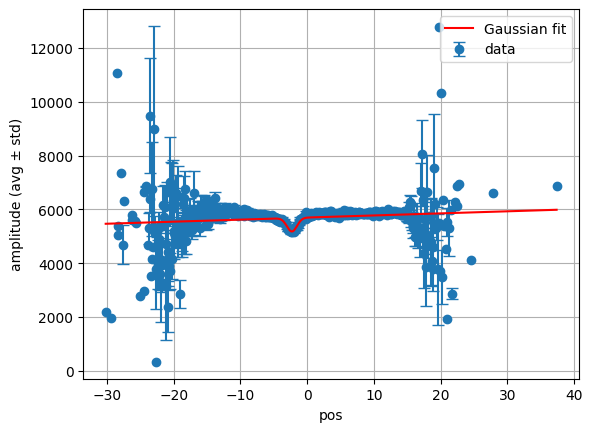

In [82]:

y_max, y_min = 10, -10

data = hit_data_scope_1081[(hit_data_scope_1081.y < y_max) & (hit_data_scope_1081.y > y_min)]
data = data[ak.num(data) > 0]

# compute X and E
X = -ak.to_numpy(ak.mean(data.x, axis=1))
X = np.round(X,1)
E = ak.sum(data.amp, axis=1)

# grouping
amp, mean, pos = rf.ak_groupby(X, E, round="false")
amp_avg = ak.mean(amp.data, axis=1)
amp_std = ak.std(amp.data, axis=1) / np.sqrt(ak.num(amp.data, axis=1) - 1)

# mask
# mask = (pos > -20) & (pos < 15)
mask = (pos > min(X)) & (pos < max(X))

# convert Awkward → Numpy
pos_m = ak.to_numpy(pos[mask])
amp_m = ak.to_numpy(amp_avg[mask])
err_m = ak.to_numpy(amp_std[mask])

# --- Gaussian model ---
def gaussian_linear(x, c, m, A, mu, sigma):
    return c + m*x - A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# initial guesses
c0 = 6000
m0 = 0
A0 = np.min(amp_m)
# A0 = np.max(amp_m)
# mu0 = pos_m[np.argmin(amp_m)]
mu0 = 0
sigma0 = 3
# sigma0 = (np.max(pos_m) - np.min(pos_m)) / 6

# fit
popt, pcov = curve_fit(gaussian_linear, pos_m, amp_m, p0=[c0, m0, A0, mu0, sigma0])

c_fit, m_fit, A_fit, mu_fit, sigma_fit = popt

print("Gaussian fit parameters:")
print(f"c     = {c_fit:.3f}")
print(f"m     = {m_fit:.3f}")
print(f"theta     = {np.arctan(m_fit):.3f} Radians")
print(f"A     = {A_fit:.3f}")
print(f"mu    = {mu_fit:.3f}")
print(f"sigma = {sigma_fit:.3f}")

# make smooth curve for plotting
x_fit = np.linspace(np.min(pos_m), np.max(pos_m), 500)
y_fit = gaussian_linear(x_fit, *popt)

# --- plotting ---
plt.errorbar(pos_m, amp_m, yerr=err_m, fmt='o', capsize=4, label="data")
plt.plot(x_fit, y_fit, 'r-', label="Gaussian fit", zorder=10)

plt.grid()
plt.xlabel("pos")
plt.ylabel("amplitude (avg ± std)")
plt.legend()
plt.show()


In [84]:
# show the average amp vs x position and perform gaussian + linear fit
def gap_avg_eneregies_per_X_fit(hit_data_scope, y_min, y_max):
    y_max, y_min = 10, -10

    data = hit_data_scope[(hit_data_scope.y < y_max) & (hit_data_scope.y > y_min)]
    data = data[ak.num(data) > 0]

    # compute X and E
    X = -ak.to_numpy(ak.mean(data.x, axis=1))
    X = np.round(X,1)
    E = ak.sum(data.amp, axis=1)

    # grouping
    amp, mean, pos = rf.ak_groupby(X, E, round="false")
    amp_avg = ak.mean(amp.data, axis=1)
    amp_std = ak.std(amp.data, axis=1) / np.sqrt(ak.num(amp.data, axis=1) - 1)

    # mask
    # mask = (pos > -20) & (pos < 15)
    mask = (pos > min(X)) & (pos < max(X))

    # convert Awkward → Numpy
    pos_m = ak.to_numpy(pos[mask])
    amp_m = ak.to_numpy(amp_avg[mask])
    err_m = ak.to_numpy(amp_std[mask])

    # --- Gaussian model ---
    def gaussian_linear(x, c, m, A, mu, sigma):
        return c + m*x - A * np.exp(-(x - mu)**2 / (2 * sigma**2))

    # initial guesses
    c0 = 6000
    m0 = 0
    A0 = np.min(amp_m)
    # A0 = np.max(amp_m)
    # mu0 = pos_m[np.argmin(amp_m)]
    mu0 = 0
    sigma0 = 3
    # sigma0 = (np.max(pos_m) - np.min(pos_m)) / 6

    # fit
    popt, pcov = curve_fit(gaussian_linear, pos_m, amp_m, p0=[c0, m0, A0, mu0, sigma0])
    c_fit, m_fit, A_fit, mu_fit, sigma_fit = popt

    print("Gaussian fit parameters:")
    print(f"c     = {c_fit:.3f}")
    print(f"m     = {m_fit:.3f}")
    print(f"theta     = {np.arctan(m_fit):.3f} Radians")
    print(f"A     = {A_fit:.3f}")
    print(f"mu    = {mu_fit:.3f}")
    print(f"sigma = {sigma_fit:.3f}")

    # make smooth curve for plotting
    x_fit = np.linspace(np.min(pos_m), np.max(pos_m), 500)
    y_fit = gaussian_linear(x_fit, *popt)

    # --- plotting ---
    plt.errorbar(pos_m, amp_m, yerr=err_m, fmt='o', capsize=4, label="data")
    plt.plot(x_fit, y_fit, 'r-', label="Gaussian fit", zorder=10)

    plt.grid()
    plt.xlabel("pos")
    plt.ylabel("amplitude (avg ± std)")
    plt.legend()
    plt.show()


Gaussian fit parameters:
c     = 5699.363
m     = 7.688
theta     = 1.441 Radians
A     = 501.041
mu    = -2.275
sigma = 0.751


C:\Users\bents\AppData\Local\Programs\Python\Python313\Lib\site-packages\awkward\_nplikes\array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


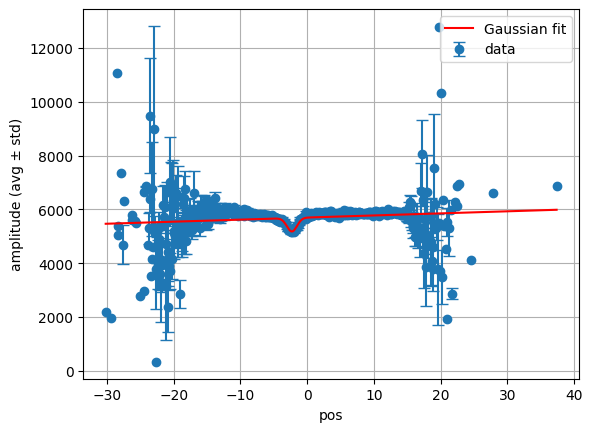

In [85]:
gap_avg_eneregies_per_X_fit(hit_data_scope_1081, -10,10)

C:\Users\bents\AppData\Local\Programs\Python\Python313\Lib\site-packages\awkward\_nplikes\array_module.py:292: RuntimeWarning: invalid value encountered in divide
  return impl(*broadcasted_args, **(kwargs or {}))


Text(0, 0.5, 'amplitude (avg ± std)')

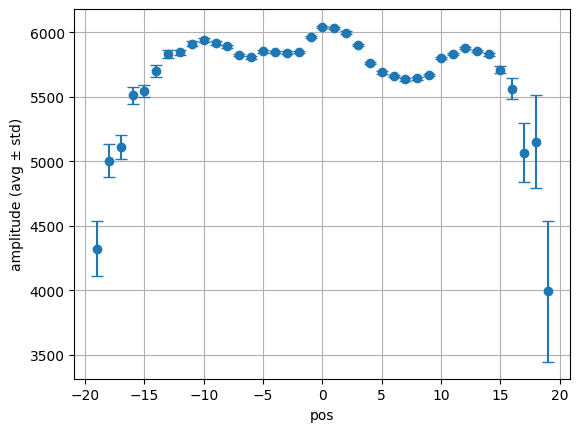

In [ ]:
X = -ak.to_numpy(ak.mean(hit_data_scope_1093.x, axis=1))
np.round(X)
E = ak.sum(hit_data_scope_1093.amp, axis = 1)
amp,mean,pos = rf.ak_groupby(X,E)
amp_avg = ak.mean(amp.data, axis = 1)
amp_std = ak.std(amp.data, axis = 1) / np.sqrt(ak.num(amp.data, axis = 1) -1)
mask = (pos > -20) & (pos < 20) 
# plt.scatter(pos[mask],amp[mask])
plt.errorbar(pos[mask],amp_avg[mask],yerr=amp_std[mask],fmt='o',capsize=4)
plt.grid()
plt.xlabel("pos")
plt.ylabel("amplitude (avg ± std)")


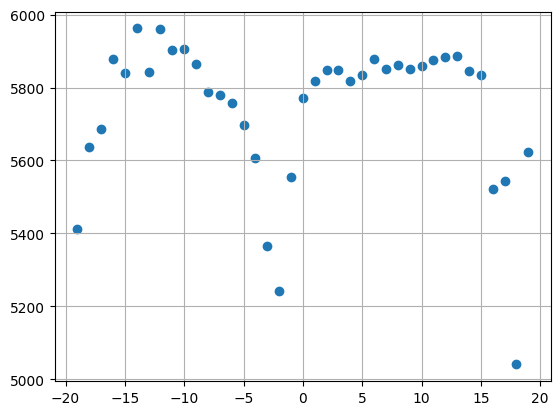

In [ ]:
X = -ak.to_numpy(ak.mean(hit_data_scope_1081.x, axis=1))
np.round(X)
E = ak.sum(hit_data_scope_1081.amp, axis = 1)
data,amp,pos = rf.ak_groupby(X,E)
mask = (pos > -20) & (pos < 20) 
plt.scatter(pos[mask],amp[mask])
plt.grid()